<h1><strong><u>Multi-layered Perceptron Model</u></strong></h1>

<h2><strong><u>Data Preparation</u></strong></h2>

In [1]:
%%capture
%run DataPreparation.ipynb

<h2><strong><u>MLP Model Selection</u></strong></h2>

<h3><strong><u>Validation Curves</u></strong></h3>

In [2]:
# Validation Curve for Testing Regularization Coefficient Ranges

pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)),
        ("clf", MLPClassifier(hidden_layer_sizes=(10,))),
    ]
)
alphas = [0.0001, 0.001, 0.01, 0.1, 1]
train_scores, validation_scores = validation_curve(pipeline, X_train, y_train, cv=5, scoring='accuracy',
                                                   param_name="clf__alpha",
                                                   param_range=alphas,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

vc_dict[f"MLP Classifier: Accuracy VC (Reg Coef. 1)"] = [["Regularization Coefficient", "Accuracy Score"],
                                                       alphas,
                                                       [train_scores_mean, validation_scores_mean],
                                                       ["Train Scores", "Validation Scores"]]

In [3]:
# Validation Curve for Testing Regularization Coefficient Ranges (Cont'd)

pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)),
        ("clf", MLPClassifier(hidden_layer_sizes=(10,))),
    ]
)

alphas = list(range(1,11))
train_scores, validation_scores = validation_curve(pipeline, X_train, y_train, cv=5, scoring='accuracy',
                                                   param_name="clf__alpha",
                                                   param_range=alphas,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

vc_dict[f"MLP Classifier: Accuracy VC (Reg Coef. 2)"] = [["Regularization Coefficient", "Accuracy Score"],
                                                       alphas,
                                                       [train_scores_mean, validation_scores_mean],
                                                       ["Train Scores", "Validation Scores"]]

In [4]:
# Validation Curve for Testing Effect of Neuron Count

pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)),
        ("clf", MLPClassifier(alpha=1)),
    ]
)

hidden_layers = [(4,), (8,), (12,), (16,), (20,), (24,)]
neurons = list(range(4, 25, 4))
train_scores, validation_scores = validation_curve(pipeline, X_train, y_train, cv=5, scoring='accuracy',
                                                   param_name="clf__hidden_layer_sizes",
                                                   param_range=hidden_layers,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

vc_dict[f"MLP Classifier: Accuracy VC (Neuron Count with One Layer)"] = [["Neuron Count", "Accuracy Score"],
                                                                          neurons,
                                                                          [train_scores_mean, validation_scores_mean],
                                                                          ["Train Scores", "Validation Scores"]]

In [5]:
# Validation Curve for Testing Effect of Adding Hidden Layers

pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)),
        ("clf", MLPClassifier(alpha=1, max_iter=500)),
    ]
)

hidden_layers_sizes = [(14,), (14,2), (14,3), (14,4), (14,5)]
hidden_layers = list(range(1,6))
train_scores, validation_scores = validation_curve(pipeline, X_train, y_train, cv=5, scoring='accuracy',
                                                   param_name="clf__hidden_layer_sizes",
                                                   param_range=hidden_layers_sizes,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

vc_dict[f"MLP Classifier: Accuracy VC (Hidden Layer Size)"] = [["Hidden Layer Size", "Accuracy Score"],
                                                                hidden_layers,
                                                                [train_scores_mean, validation_scores_mean],
                                                                ["Train Scores", "Validation Scores"]]

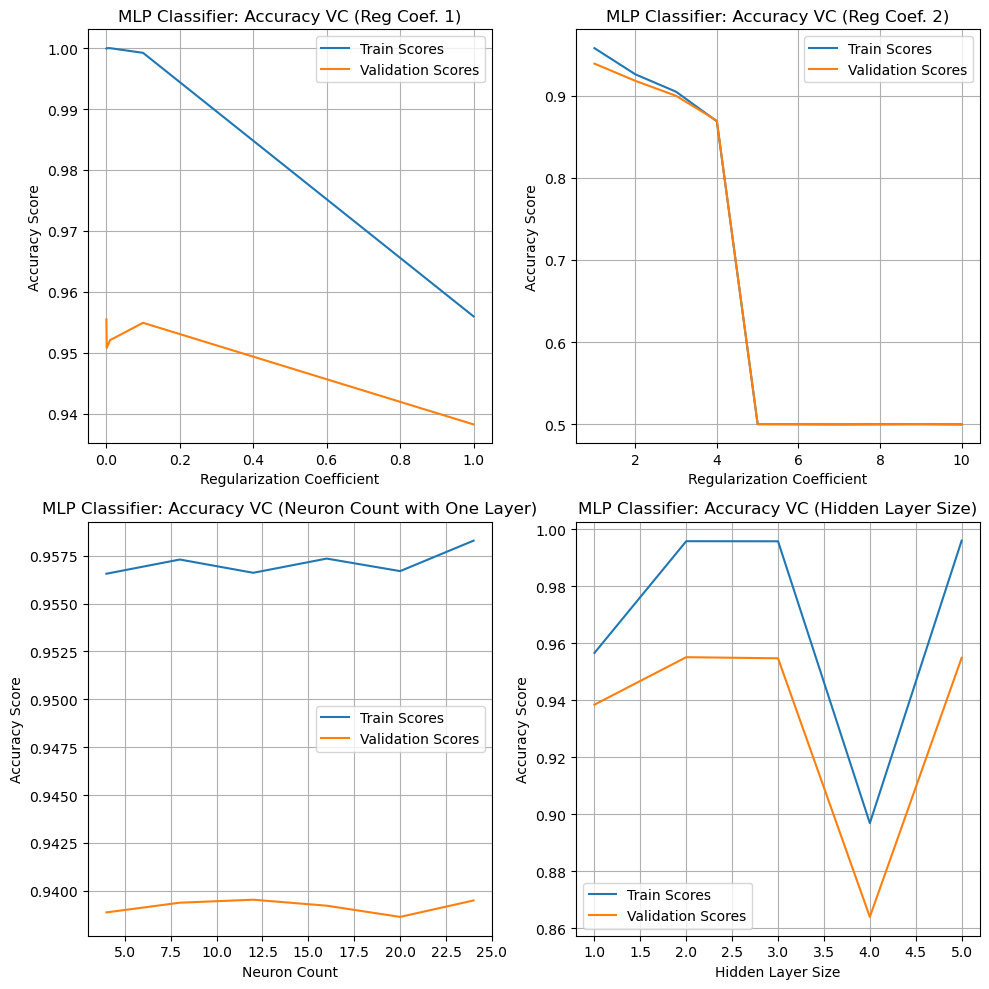

In [6]:
# Create an even number of subplots (e.g., 3 rows, 2 columns for 5 plots)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes array for easier iteration
axs = axs.flatten()
count = 0
for key, value in vc_dict.items():
    axs[count].plot(value[1], value[2][0], label=value[3][0])
    axs[count].plot(value[1], value[2][1], label=value[3][1])
    axs[count].set_xlabel(value[0][0])
    axs[count].set_ylabel(value[0][1])
    axs[count].set_title(key)
    axs[count].grid()
    axs[count].minorticks_off()
    axs[count].legend()
    count += 1

plt.tight_layout()
plt.show()

<h3><strong><u>Cross Validation Testing</u></strong></h3>

In [7]:
pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)),
        ("clf", MLPClassifier(alpha=1, max_iter=1000)),
    ]
)
param_grid = {
    "clf__hidden_layer_sizes": [(12,), (14,), (16,), (18,), (20,)]
    }

model = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
model.fit(X_train, y_train)
mlp_classifier = model.best_estimator_

In [8]:
print(model.best_params_)

def mlp_clickbait_classifier():
    return mlp_classifier

{'clf__hidden_layer_sizes': (16,)}


<h4><strong><u>Findings From 'Model Selection' Section</u></strong></h4>
The parameters that were of interest in validation curve tests were hidden layer sizes and the regularization coefficient. After investigating all of the validation curves, I found that the sweet spot for generalization was at a low neuron count with a single layer and a regularization coefficient of 1.

<h2><strong><u>Model Evaluation</u></strong></h2>

<h3><strong><u>Learning Curve</u></strong></h4>

In [9]:
for key, value in clf_metrics.items():
    mlp_train_sizes, mlp_train_scores, mlp_validation_scores = learning_curve(
        mlp_classifier,
        X_train,
        y_train,
        cv=5,  # Number of folds for cross-validation
        scoring=value,  # Metric to evaluate the model
        n_jobs=-1,  # Use all available CPU cores
    )

    # Calculate mean and standard deviation for scores
    mlp_train_scores_mean = np.mean(mlp_train_scores, axis=1)
    mlp_train_scores_std = np.std(mlp_train_scores, axis=1)
    mlp_validation_scores_mean = np.mean(mlp_validation_scores, axis=1)
    mlp_validation_scores_std = np.std(mlp_validation_scores, axis=1)

        # Calculate spread of data around the mean
    mlp_train_range_minus = mlp_train_scores_mean - mlp_train_scores_std
    mlp_train_range_plus = mlp_train_scores_mean + mlp_train_scores_std
    mlp_validation_range_minus = mlp_validation_scores_mean - mlp_validation_scores_std
    mlp_validation_range_plus = mlp_validation_scores_mean + mlp_validation_scores_std

    lc_dict[key] = [[mlp_train_scores_mean, mlp_validation_scores_mean],
                    [mlp_train_range_minus, mlp_train_range_plus], 
                    [mlp_validation_range_minus, mlp_validation_range_plus], 
                    mlp_train_sizes]

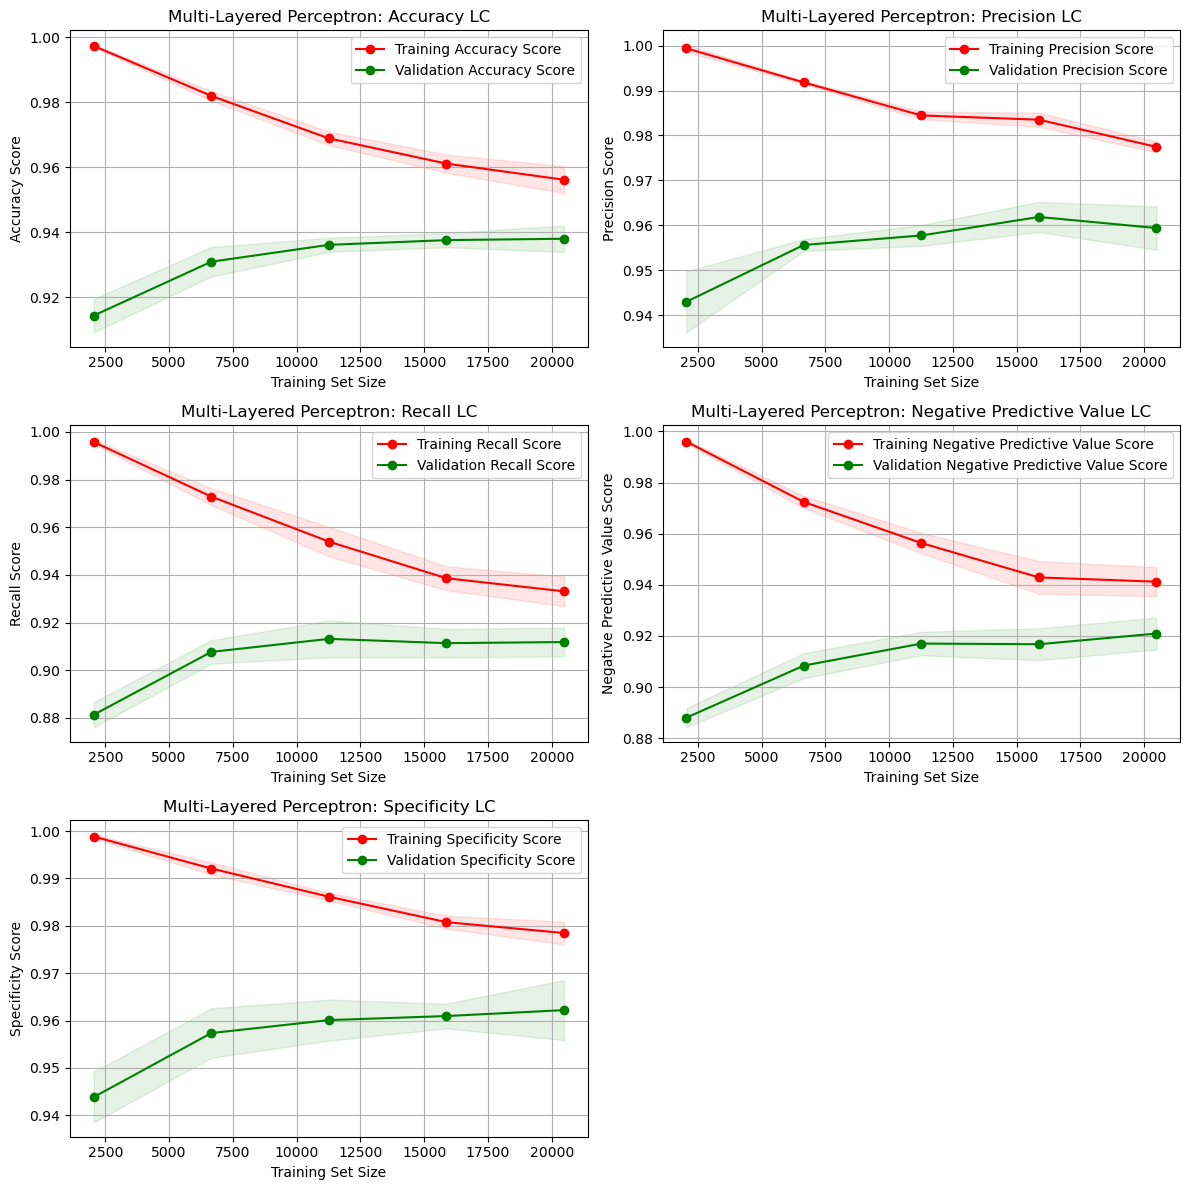

In [10]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# Flatten the axes array for easier iteration
axs = axs.flatten()
count = 0
for key, value in lc_dict.items():
    axs[count].set_title(f"Multi-Layered Perceptron: {key} LC")
    axs[count].set_xlabel("Training Set Size")
    axs[count].set_ylabel(f"{key} Score")
    axs[count].grid()

    axs[count].fill_between(value[3], value[1][0], value[1][1], alpha=0.1, color="r")
    axs[count].fill_between(value[3], value[2][0], value[2][1], alpha=0.1, color="g")
    axs[count].plot(value[3], value[0][0], 'o-', color="r", label=f"Training {key} Score")
    axs[count].plot(value[3], value[0][1], 'o-', color="g", label=f"Validation {key} Score")
    axs[count].legend()
    count += 1
    
fig.delaxes(axs[count]) 

plt.tight_layout()
plt.show()

<h3><strong><u>Evaluation Metrics</u></strong></h3>

In [ ]:
for key, value in clf_metrics.items():
    nb_training_values = cross_val_score(mlp_classifier, X_train, y=y_train, scoring=value, cv=5)
    np_nb_training_values = np.array(nb_training_values)
    average = np.mean(np_nb_training_values)
    stDev = np.std(np_nb_training_values)
    cvs_dict[key] = [nb_training_values, [average, stDev]]

In [ ]:
for key, value in cvs_dict.items():
    print(f"{key}")
    print("CV Training Scores: ", value[0])
    print(f"Training Average and Standard Error: ", "{:.2f}%".format(value[1][0].round(2)), "\u00B1", "{:.2f}%".format(value[1][1].round(4)*100), "\n")

Accuracy
CV Training Scores:  [0.94121094 0.93789062 0.93476563 0.9421875  0.93652344]
Training Average and Standard Error:  0.94% ± 0.28% 

Precision
CV Training Scores:  [0.96452145 0.96516995 0.9601825  0.9657308  0.95074089]
Training Average and Standard Error:  0.96% ± 0.56% 

Recall
CV Training Scores:  [0.91282252 0.91402892 0.9003517  0.91246581 0.92145369]
Training Average and Standard Error:  0.91% ± 0.68% 

Negative Predictive Value
CV Training Scores:  [0.92626035 0.90422433 0.91056911 0.91528545 0.91509084]
Training Average and Standard Error:  0.91% ± 0.72% 

Specificity
CV Training Scores:  [0.97501952 0.95626708 0.96251464 0.96759078 0.95665756]
Training Average and Standard Error:  0.96% ± 0.71% 



Text(0.5, 1.0, 'Multi-Layered Perceptron: Confusion Matrix (Evaluation)')

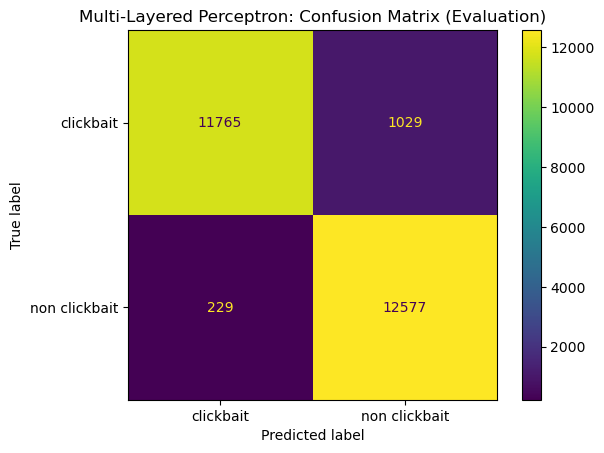

In [13]:
#Training Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(mlp_classifier, X_train, y_train, labels=['clickbait', 'non clickbait'])
disp.ax_.set_title("Multi-Layered Perceptron: Confusion Matrix (Evaluation)")

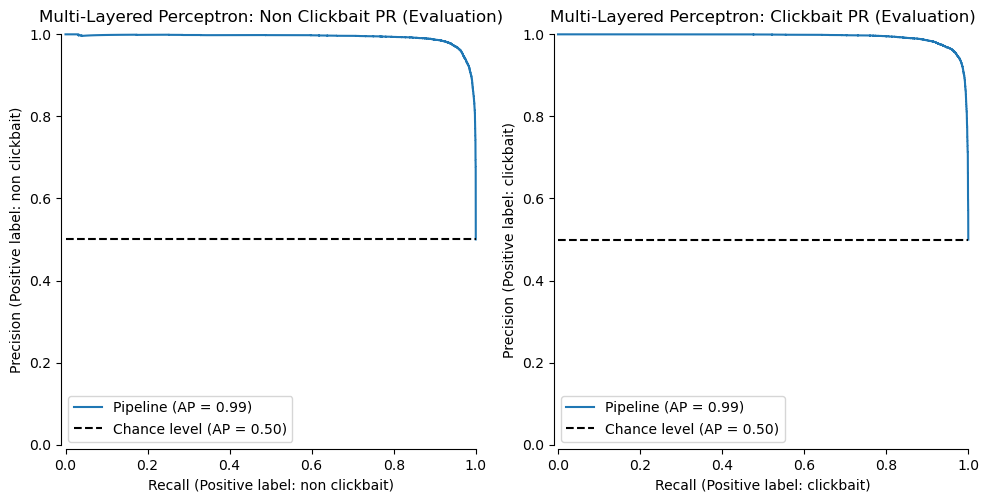

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs = axs.flatten()
count = 0
for label in train_labels:
    disp = PrecisionRecallDisplay.from_estimator(mlp_classifier, X_train, y_train, ax=axs[count], pos_label=label, plot_chance_level=True, despine=True)
    disp.ax_.set_title(f"Multi-Layered Perceptron: {label.title()} PR (Evaluation)")
    count += 1

plt.tight_layout()  
plt.show()

<h4><strong><u>Findings From 'Model Evaluation' Phase</u></strong></h4>
In the evaluation of my selected Multi-Layered Perceptron model, I found positive results for all evaluation methods. I believe that the overall shape of the learning curve is good with both of the training and the validation scores diverging towards each other. This suggests that the model is prioritizing the general logic of the dataset over being completely accurate. The 'cross_val_score' function evaluation results reinforced the learning curve values. In addition, the Confusion Matrix and the Precision-Recall plots show good results. Therefore, I will move forward with this model to the 'Final Model Testing' phase.